# Collaborators:

- Niels Savvides
- Matisse Callewaert

# Lab IV: Multi-view Geometry

## Define Imports

In [412]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Helper Functions

In [413]:
def draw_lines(img1, img2, lines, pts1, pts2):
    '''Draw epilines for the points in img2 on img1 and vice versa'''
    r,c = img1.shape
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -line[2]/line[1] ])
        x1,y1 = map(int, [c, -(line[2]+line[0]*c)/line[1] ])
        pt1 = (int(pt1[0][0]), int(pt1[0][1]))
        pt2 = (int(pt2[0][0]), int(pt2[0][1]))
        img1_color = cv2.line(img1_color, (x0,y0), (x1,y1), color,1)
        img1_color = cv2.circle(img1_color, pt1, 5, color, -1)
        img2_color = cv2.circle(img2_color, pt2, 5, color, -1)
    return img1_color, img2_color


## 1: Epipoles and the fundamental matrix

### Exercise 1:

**Write a program that computes the fundamental matrix between im00.png and im01.png and shows the
epipolar lines**

### Assignment 1

**Compute SIFT keypoints and descriptors in both images and match them. Use k nearest
neighbor matching and reject ambiguous matches based on Lowe’s ratio test. Show the matches.**

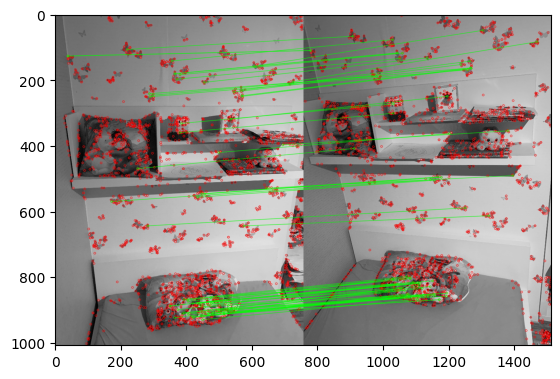

(<matplotlib.image.AxesImage at 0x26a04978490>, None)

In [414]:
# Load the images
img1 = cv2.imread('source_images/im00.png', cv2.IMREAD_GRAYSCALE)  # QueryImage
img2 = cv2.imread('source_images/im01.png', cv2.IMREAD_GRAYSCALE)  # TrainImage

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# FLANN based matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# k-nearest neighbors matching
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.4*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
 
img3 = cv2.drawMatchesKnn(img1, keypoints1,img2,keypoints2,matches,None,**draw_params)
 
plt.imshow(img3,),plt.show()

### Assignment 2

**Estimate the fundamental matrix using findFundamentalMat, compute the epipolar lines
for the feature points you used (you can use computeCorrespondEpilines) and draw these onto both
images**

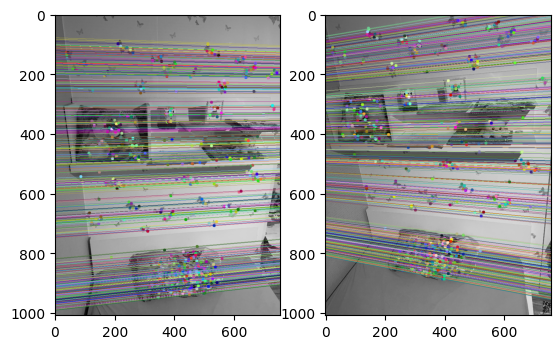

In [415]:
pts1 = []
pts2 = []
 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(keypoints2[m.trainIdx].pt)
        pts1.append(keypoints1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
 
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
 
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## 2: The essential matrix

### Exercise 2:

**Compute the essential matrix, given that the camera used for both images has the following calibration
matrix:**

\begin{bmatrix}
792 & 0 & 505 \\
0 & 791 & 376 \\
0 & 0 & 1 \\
\end{bmatrix}

### Assignment 3

- **Compute the essential matrix from the fundamental matrix you estimated in Assignment 2, using
Equation 7 (E = $C′^T$ FC) and the matrix above.**

In [416]:
print(pts1)

[[ 38 127]
 [ 38 127]
 [ 39 136]
 ...
 [733 188]
 [739 192]
 [742 197]]


In [417]:
# Given intrinsic camera matrix
C = np.array([
    [792, 0, 505],
    [0, 791, 376],
    [0, 0, 1]
])

# Compute the essential matrix E
E = C.T @ F @ C

In [418]:
print(E)

[[   6.69484701  202.65968845  -25.4876965 ]
 [  80.46216992  -44.26317995 -581.16705098]
 [  16.92867856  652.92645438  -48.87977086]]


- **Compute the translation and rotation from the essential matrix using decomposeEssentialMat.
Print the rotation and translation matrices in your report**

In [419]:
R1, R2, t = cv2.decomposeEssentialMat(E)

print("Possible Rotation Matrix R1:\n", R1)
print("Possible Rotation Matrix R2:\n", R2)
print("Possible Translation t (up to scale):\n", t)

Possible Rotation Matrix R1:
 [[ 0.90507674  0.02486331  0.4245208 ]
 [ 0.00934702  0.99688498 -0.07831331]
 [-0.42514553  0.07484755  0.90202501]]
Possible Rotation Matrix R2:
 [[ 0.98554494 -0.05411971 -0.16053731]
 [-0.04271643 -0.9963686   0.07365401]
 [-0.16394047 -0.06573175 -0.98427784]]
Possible Translation t (up to scale):
 [[ 0.95459331]
 [-0.01684854]
 [-0.29743527]]


#### Question 1:

**You get two possible rotation matrices, which one do you think is correct? Hint: read Question
3 below.**

>

### Assignment 4

- **Convert the keypoint coordinates you used in Assignment 2 to normalized coordinates (for both images).**

In [420]:
import numpy as np

# Function to normalize keypoints
def normalize_keypoints(pts, image_width, image_height):
    normalized_pts = []
    for pt in pts:
        x, y = pt
        normalized_x = x / image_width
        normalized_y = y / image_height
        normalized_pts.append((normalized_x, normalized_y))
    return np.array(normalized_pts)

# Normalize keypoints for both images
image1_width = img1.shape[1]  # Assuming image1 is your first image
image1_height = img1.shape[0]
image2_width = img2.shape[1]  # Assuming image2 is your second image
image2_height = img2.shape[0]

normalized_pts1 = normalize_keypoints(pts1, image1_width, image1_height)
normalized_pts2 = normalize_keypoints(pts2, image2_width, image2_height)

# Now you have normalized keypoints
print("Normalized Keypoints for Image 1:", normalized_pts1)
print("Normalized Keypoints for Image 2:", normalized_pts2)


Normalized Keypoints for Image 1: [[0.05026455 0.12599206]
 [0.05026455 0.12599206]
 [0.0515873  0.13492063]
 ...
 [0.96957672 0.18650794]
 [0.97751323 0.19047619]
 [0.98148148 0.19543651]]
Normalized Keypoints for Image 2: [[0.02777778 0.10912698]
 [0.02777778 0.10912698]
 [0.02910053 0.11706349]
 ...
 [0.51587302 0.1031746 ]
 [0.52910053 0.10714286]
 [0.53439153 0.11309524]]


In [421]:
print("points_1 normalized:\n\n", normalized_pts1, "\n")

print("points_1 normalized:\n\n", normalized_pts2)

points_1 normalized:

 [[0.05026455 0.12599206]
 [0.05026455 0.12599206]
 [0.0515873  0.13492063]
 ...
 [0.96957672 0.18650794]
 [0.97751323 0.19047619]
 [0.98148148 0.19543651]] 

points_1 normalized:

 [[0.02777778 0.10912698]
 [0.02777778 0.10912698]
 [0.02910053 0.11706349]
 ...
 [0.51587302 0.1031746 ]
 [0.52910053 0.10714286]
 [0.53439153 0.11309524]]


- **Compute the essential matrix by using findFundamentalMat on the normalized points.**

In [423]:
F, mask = cv2.findFundamentalMat(normalized_pts1, normalized_pts2, cv2.FM_LMEDS)
E = C.T @ F @ C
print("Essential Matrix E:\n", E)

Essential Matrix E:
 [[-2.57636549e+06  5.32934321e+07  2.36708087e+07]
 [ 1.07437925e+08 -3.84881743e+07  4.97066916e+07]
 [ 4.93721837e+07  1.61371029e+07  3.89001672e+07]]


- **Compute the translation and rotation matrices once again with decomposeEssentialMat and print
them in your report. They should be close to results from Assignment 3, if not, you have a problem!**

In [426]:
# Assuming E is the essential matrix computed from findEssentialMat
R1, R2, t = cv2.decomposeEssentialMat(E)

print("Possible Rotation Matrix R1:\n", R1)
print("Possible Rotation Matrix R2:\n", R2)
print("Possible Translation t (up to scale):\n", t)

Possible Rotation Matrix R1:
 [[ 0.49964615 -0.35340478  0.79085952]
 [-0.35349312 -0.91669624 -0.18630787]
 [ 0.79082004 -0.18647539 -0.58294991]]
Possible Rotation Matrix R2:
 [[-9.99761339e-01 -2.18418074e-02 -4.47197118e-04]
 [-1.43408261e-02  6.40702952e-01  7.67654915e-01]
 [-1.64804503e-02  7.67478119e-01 -6.40863271e-01]]
Possible Translation t (up to scale):
 [[ 0.50390397]
 [ 0.37062059]
 [-0.78020585]]


#### Question 2:

**The translation is only up to a scale factor. Does it correspond to your visual assessment of
the perspective difference between the shots? Explain.**

>

#### Question 3:

**Assuming that this rotation matrix would be a pure rotation along the Y axis (vertical), what
would be the approximate angle of the rotation?**

>